# 1. Import

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from basic_functions import data_load, save_df, evaluate_model
import numpy as np

Loading all the neccesary data

In [10]:
X_train = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

Data loaded!
Data loaded!


# 2. Decision Tree

## 2.1 Initial Model Pipeline

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier


pipe_dt = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("dt", DecisionTreeClassifier())
])

## 2.2 Grid Search & CV

Grid Search Function

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

def run_gridsearch(pipe, param_grid, X, y, name):
    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=2,
        refit="f1_macro"
    )

    gs.fit(X, y)
    print(f"{name} best params: {gs.best_params_} | best f1: {gs.best_score_:.4f}")
    return gs

Randomized Grid Search Function

In [13]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

def run_randomgridsearch(pipe, param_grid, X, y, name, iterations):
    rgs = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit="f1_macro",
        verbose=2,
        n_iter=iterations
    )

    rgs.fit(X, y)
    print(f"{name} best params: {rgs.best_params_} | best f1: {rgs.best_score_:.4f}")
    return rgs

calculation of different metrics with cross validation

In [14]:
from sklearn.model_selection import cross_validate

def calculate_cv(pipeline, X, y, cv, scoring, show_results = True):

    cv_results   = cross_validate(pipeline, X.astype("category"), y, cv=cv, scoring=scoring)
    
    if show_results:
        for metric in scoring.keys():
            mean = cv_results[f"test_{metric}"].mean()
            std = cv_results[f"test_{metric}"].std()
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    return cv_results

## 2.3 Run Grid Search

In [15]:
# Param Grid
param_grid_dt = {
    "dt__max_depth": [5, 10, 15, 20, 30, None],
    "dt__min_samples_split": [2, 3, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 3, 4, 8],
    "dt__criterion": ["gini", "entropy", "log_loss"]
}

In [16]:
gs_dt = run_gridsearch(pipe_dt, param_grid_dt, X_train, y_train["income"], "DecisionTree")

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
DecisionTree best params: {'dt__criterion': 'gini', 'dt__max_depth': 30, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2} | best f1: 0.7592


In [17]:
_ = calculate_cv(gs_dt.best_estimator_, X_train, y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.7819 ± 0.0080
f1_macro: 0.7558 ± 0.0091
neg_log_loss: -4.6845 ± 0.0992


--> Overconfident tree

## 2.4 Calibrated Classifier

In [18]:
from sklearn.calibration import CalibratedClassifierCV
pipe_dt_cal = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("cal", CalibratedClassifierCV(
        estimator=DecisionTreeClassifier(
        criterion="entropy",
        max_depth=None,  
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
        ),
        method="sigmoid", 
        cv=3  
    ))
])

In [19]:
_ = calculate_cv(pipe_dt_cal, X_train, y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.7933 ± 0.0109
f1_macro: 0.7669 ± 0.0102
neg_log_loss: -0.6525 ± 0.0101


# 3. Validiation on Test Data

In [20]:
pipe_dt_cal.fit(X_train, y_train["income"])

,steps,"[('oe', ...), ('cal', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,dtype,<class 'numpy.float64'>
,handle_unknown,'use_encoded_value'
,unknown_value,-1
,encoded_missing_value,nan
,min_frequency,None
,max_categories,None


In [21]:
X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")

Data loaded!
Data loaded!


In [22]:
y_pred_dt_cal = pipe_dt_cal.predict(X_test)
y_proba_dt_cal = pipe_dt_cal.predict_proba(X_test)

In [23]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

print("Accuracy:", accuracy_score(y_test["income"], y_pred_dt_cal))
print("F1_macro:", f1_score(y_test["income"], y_pred_dt_cal, average="macro"))
print("Log Loss:", log_loss(y_test["income"], y_proba_dt_cal))

Accuracy: 0.8189790870249607
F1_macro: 0.7945029626281275
Log Loss: 0.5891776479974165


## 3.1 Feature Importance

In [24]:
cal_step = pipe_dt_cal.named_steps["cal"]

dt_model = cal_step.calibrated_classifiers_[0].estimator

importances = dt_model.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)
feat_importances.sort_values(ascending=False).head(10)

job                          0.343668
employment_sector            0.148429
highest_qualification        0.088549
educational_qualification    0.085416
employment_position          0.079365
marital_status               0.066938
federal_state                0.050425
Household relationship       0.044118
gender                       0.040892
citizenship                  0.020036
dtype: float64

# 4. Random Forest Classifier

## 4.1 Initial Model Pipeline

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier


pipe_rfc = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("rf", RandomForestClassifier())
])

## 4.2 Parametertraining with random gs

In [26]:
random_grid = {
    'rf__n_estimators': np.arange(100, 501, 50),
    'rf__max_depth': [None, 10, 20, 30, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy', 'log_loss']
}

In [27]:
rgs_rfc = run_randomgridsearch(pipe=pipe_rfc, param_grid=random_grid, X=X_train, y=y_train["income"], name= "RandomForest", iterations=100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomForest best params: {'rf__n_estimators': np.int64(350), 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__criterion': 'entropy', 'rf__bootstrap': True} | best f1: 0.7765


In [28]:
_ = calculate_cv(rgs_rfc.best_estimator_, X=X_train, y=y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.8021 ± 0.0099
f1_macro: 0.7716 ± 0.0103
neg_log_loss: -0.6338 ± 0.0689


Better accuracy and f1 but worse log_loss

## 4.3 Parametertraining with gs (smaller grid)

In [29]:
param_grid_rf = {
    'rf__n_estimators': np.arange(100, 300, 50),
    'rf__max_depth': [None],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy']
}

In [30]:
gs_rfc = run_gridsearch(pipe=pipe_rfc, param_grid=param_grid_rf, X=X_train, y=y_train["income"], name="RandomForest")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
RandomForest best params: {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__n_estimators': np.int64(250)} | best f1: 0.7780


In [31]:
_ = calculate_cv(gs_rfc.best_estimator_, X=X_train, y=y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.8047 ± 0.0113
f1_macro: 0.7762 ± 0.0138
neg_log_loss: -0.6213 ± 0.0433


## 4.4 Calibrated Random Forest

In [32]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

best_rf = gs_rfc.best_estimator_.named_steps["rf"]

In [33]:
pipe_rf_cal = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("cal", CalibratedClassifierCV(
        estimator=best_rf,
        method="isotonic",
        cv=5
    ))
])


In [34]:
_ = calculate_cv(pipe_rf_cal, X_train, y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.8035 ± 0.0117
f1_macro: 0.7729 ± 0.0149
neg_log_loss: -0.5243 ± 0.0108


## 4.5 Validation on Test Data

In [35]:
pipe_rf_cal.fit(X_train, y_train["income"])

,steps,"[('oe', ...), ('cal', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,dtype,<class 'numpy.float64'>
,handle_unknown,'use_encoded_value'
,unknown_value,-1
,encoded_missing_value,nan
,min_frequency,None
,max_categories,None


In [36]:
X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")

y_pred_rf_cal = pipe_rf_cal.predict(X_test)
y_proba_rf_cal = pipe_rf_cal.predict_proba(X_test)

Data loaded!
Data loaded!


In [37]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

print("Accuracy:", accuracy_score(y_test["income"], y_pred_rf_cal))
print("F1_macro:", f1_score(y_test["income"], y_pred_rf_cal, average="macro"))
print("Log Loss:", log_loss(y_test["income"], y_proba_rf_cal))

Accuracy: 0.8225770182145267
F1_macro: 0.7930419209633291
Log Loss: 0.47942339210689233


In [38]:
best_rf.fit(X_train, y_train["income"])

,n_estimators,np.int64(250)
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
y_pred_rf_uncal = best_rf.predict(X_test)
y_proba_rf_uncal = best_rf.predict_proba(X_test)

In [40]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

print("Accuracy:", accuracy_score(y_test["income"], y_pred_rf_uncal))
print("F1_macro:", f1_score(y_test["income"], y_pred_rf_uncal, average="macro"))
print("Log Loss:", log_loss(y_test["income"], y_proba_rf_uncal))

Accuracy: 0.8223521475151788
F1_macro: 0.7941105739905008
Log Loss: 0.6755254799757843


## 4.6 Realiability Plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_score, recall_score, f1_score


def plot_reliability(model_uncal, model_cal, X_test, y_test, n_bins=10):
    classes = np.unique(y_test)


    cls_uncal = model_uncal.classes_
    cls_cal   = model_cal.classes_

    n_cols = 3
    n_rows = int(np.ceil(len(classes)/n_cols))
    plt.figure(figsize=(6*n_cols, 5*n_rows))

    for i, c in enumerate(classes, 1):

        idx_uncal = np.where(cls_uncal == c)[0][0]
        idx_cal   = np.where(cls_cal   == c)[0][0]

        y_bin = (y_test == c).astype(int)

        p_uncal = model_uncal.predict_proba(X_test)[:, idx_uncal]
        p_cal   = model_cal.predict_proba(X_test)[:, idx_cal]

        prob_true_u, prob_pred_u = calibration_curve(y_bin, p_uncal, n_bins=n_bins, strategy="uniform")
        prob_true_c, prob_pred_c = calibration_curve(y_bin, p_cal,   n_bins=n_bins, strategy="uniform")

        brier_u = brier_score_loss(y_bin, p_uncal)
        brier_c = brier_score_loss(y_bin, p_cal)


        ax = plt.subplot(n_rows, n_cols, i)
        ax.plot(prob_pred_u, prob_true_u, "s-", label=f"Unkalibriert (Brier={brier_u:.3f})")
        ax.plot(prob_pred_c, prob_true_c, "s-", label=f"Kalibriert (Brier={brier_c:.3f})")
        ax.plot([0,1],[0,1], "k--", label="Perfekte Kalibrierung")
        ax.set_xlabel("Vorhergesagte Wahrscheinlichkeit")
        ax.set_ylabel("Tatsächlicher Anteil Positiv")
        ax.grid(True)
        ax.legend(loc="best")

        precision_cal = precision_score(y_bin, (p_cal >= 0.5).astype(int), zero_division=0)
        recall_cal = recall_score(y_bin, (p_cal >= 0.5).astype(int), zero_division=0)
        f1_cal = f1_score(y_bin, (p_cal >= 0.5).astype(int), zero_division=0)
        precision_uncal = precision_score(y_bin, (p_uncal >= 0.5).astype(int), zero_division=0)
        recall_uncal = recall_score(y_bin, (p_uncal >= 0.5).astype(int), zero_division=0)
        f1_uncal = f1_score(y_bin, (p_uncal >= 0.5).astype(int), zero_division=0)
        ax.set_title(f"Klasse {c}\nuncalibrated: F1={f1_uncal:.3f} | Prec={precision_uncal:.3f} | Rec={recall_uncal:.3f}\ncalibrated: F1={f1_cal:.3f} | Prec={precision_cal:.3f} | Rec={recall_cal:.3f}")


    plt.tight_layout()
    plt.show()


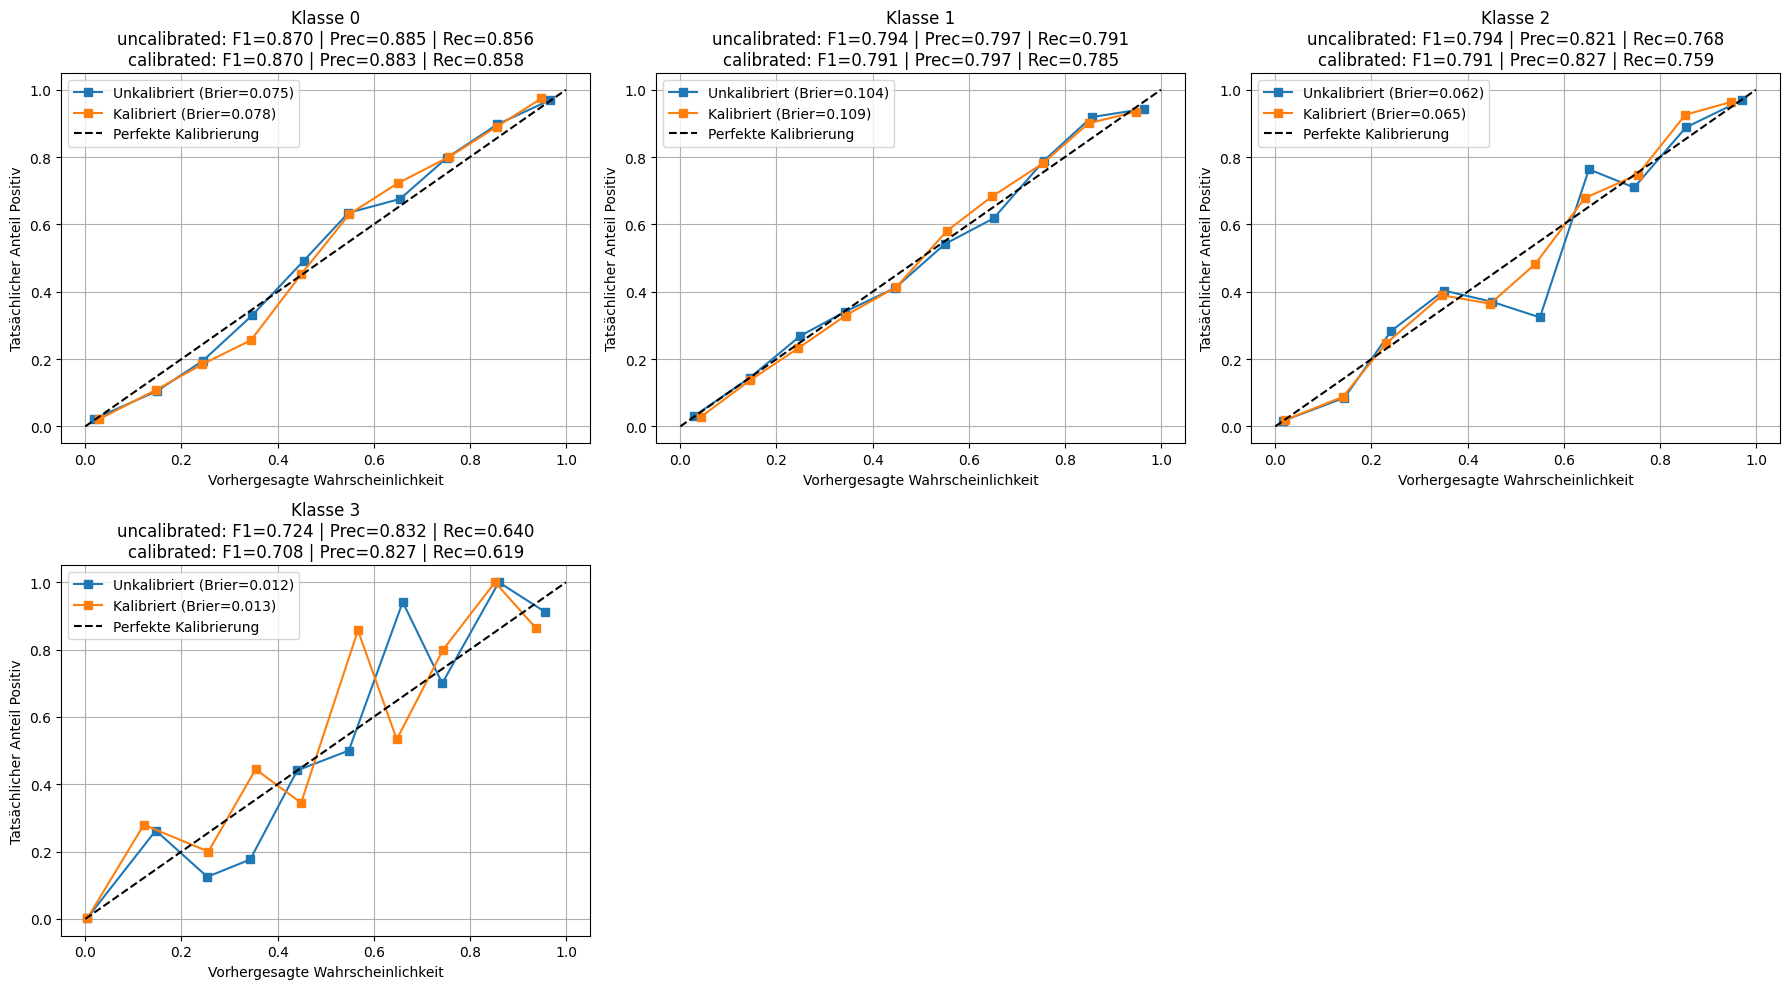

In [42]:
plot_reliability(
    model_uncal=best_rf, 
    model_cal=pipe_rf_cal,
    X_test=X_test,
    y_test=y_test["income"],
    n_bins=10
)


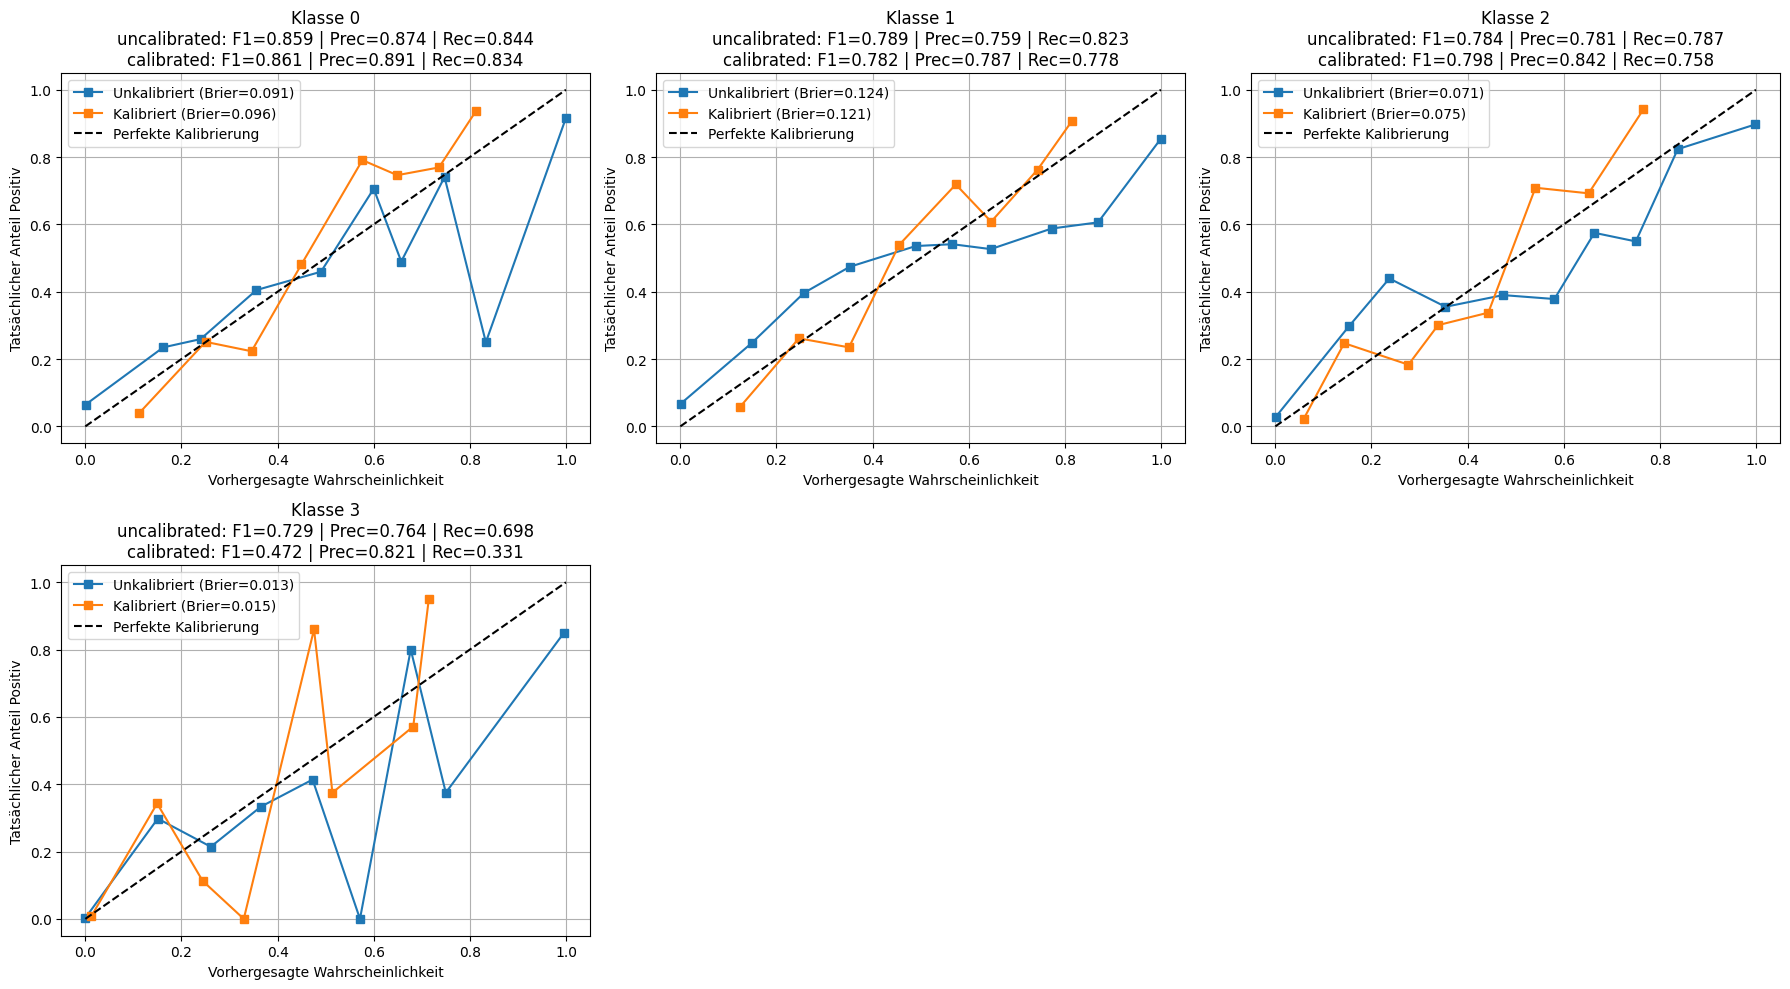

In [54]:
plot_reliability(
    model_uncal=gs_dt.best_estimator_, 
    model_cal=pipe_dt_cal,
    X_test=X_test,
    y_test=y_test["income"],
    n_bins=10
)

# 5. Comparison

calibrated Decision Tree

In [43]:
y_predict_dt_cal = pipe_dt_cal.predict(X_test)
y_probs_dt_cal = pipe_dt_cal.predict_proba(X_test)
dt_cal_eval = evaluate_model(y_pred=y_predict_dt_cal, y_test=y_test, model_name="DT_cal", y_proba=y_probs_dt_cal)

DT_cal:
Accuracy: 0.8189790870249607
Macro-F1: 0.7945029626281275
Weighted-F1: 0.8190352155963609
Log-Loss: 0.5891776479974165
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1741
           1       0.77      0.83      0.79      1581
           2       0.81      0.77      0.79       986
           3       0.84      0.64      0.73       139

    accuracy                           0.82      4447
   macro avg       0.82      0.77      0.79      4447
weighted avg       0.82      0.82      0.82      4447



uncalibrated Decision Tree

In [44]:
y_predict_dt_uncal = gs_dt.predict(X_test)
y_probs_dt_uncal = gs_dt.predict_proba(X_test)
dt_uncal_eval = evaluate_model(y_pred=y_predict_dt_uncal, y_test=y_test, model_name="DT_uncal", y_proba=y_probs_dt_uncal)

DT_uncal:
Accuracy: 0.8115583539464808
Macro-F1: 0.7844876979098333
Weighted-F1: 0.8116152668612474
Log-Loss: 3.466259109431359
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1741
           1       0.77      0.81      0.79      1581
           2       0.80      0.78      0.79       986
           3       0.78      0.65      0.71       139

    accuracy                           0.81      4447
   macro avg       0.80      0.77      0.78      4447
weighted avg       0.81      0.81      0.81      4447



uncalibrated Random Forest

In [45]:
rf_uncal_eval = evaluate_model(y_pred=y_pred_rf_uncal, y_test=y_test, model_name="RF_uncal", y_proba=y_proba_rf_uncal)

RF_uncal:
Accuracy: 0.8223521475151788
Macro-F1: 0.7941105739905008
Weighted-F1: 0.8221541889686771
Log-Loss: 0.6755254799757843
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1741
           1       0.78      0.80      0.79      1581
           2       0.80      0.79      0.79       986
           3       0.78      0.66      0.72       139

    accuracy                           0.82      4447
   macro avg       0.81      0.78      0.79      4447
weighted avg       0.82      0.82      0.82      4447



calibrated Random Forest

In [46]:
rf_cal_eval = evaluate_model(y_pred=y_pred_rf_cal, y_test=y_test, model_name="RF_cal", y_proba=y_proba_rf_cal)

RF_cal:
Accuracy: 0.8225770182145267
Macro-F1: 0.7930419209633291
Weighted-F1: 0.8223750181608489
Log-Loss: 0.47942339210689233
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1741
           1       0.78      0.80      0.79      1581
           2       0.80      0.78      0.79       986
           3       0.79      0.65      0.71       139

    accuracy                           0.82      4447
   macro avg       0.81      0.78      0.79      4447
weighted avg       0.82      0.82      0.82      4447



In [47]:
df_eval = pd.concat([
    dt_uncal_eval,
    dt_cal_eval,
    rf_uncal_eval,
    rf_cal_eval
    ], ignore_index = True)
df_eval

,Model,Accuracy,Macro-F1,Weighted-F1,Log-Loss
0,DT_uncal,0.811558,0.784488,0.811615,3.466259
1,DT_cal,0.818979,0.794503,0.819035,0.589178
2,RF_uncal,0.822352,0.794111,0.822154,0.675525
3,RF_cal,0.822577,0.793042,0.822375,0.479423


In [48]:
model_comparison = data_load("data/model_comparison.csv")
model_comparison = pd.concat([
    model_comparison,
    df_eval
], ignore_index=True)
model_comparison

Data loaded!


,Model,Accuracy,Macro-F1,Weighted-F1,Log-Loss
0,Random_Guess,0.254104,0.227097,0.281148,1.386294
1,Majority_Guess,0.391500,0.140676,0.220298,21.932567
2,CategoricalNB,0.602429,0.550775,0.603726,1.007634
3,MultinomialNB,0.602429,0.550775,0.603726,1.007529
4,ComplementNB,0.601304,0.473029,0.588944,1.049685
5,DT_uncal,0.811558,0.784488,0.811615,3.466259
6,DT_cal,0.818979,0.794503,0.819035,0.589178
7,RF_uncal,0.822352,0.794111,0.822154,0.675525
8,RF_cal,0.822577,0.793042,0.822375,0.479423


In [49]:
save_df(model_comparison, "data/model_comparison.csv")

Data saved!
